In [1]:
import numpy as np


class Node:
    def __init__(self, inputs = []):
        self.inputs = inputs
        self.outputs = []
    
        for n in self.inputs:
            n.outputs.append(self)   #A -->B  A的输出.append(B)
        
        self.value = None
    
        self.gradients = {} #keys:Node's inputs   values: partial of the node(self.value) to this node's input 
    
    def forward(self):
        #前向计算：输入 -> Node -> 输出  储存在self.values中
        
        raise NotImplemented
    
    
    def backward(self):
        #后向计算：输入<- Node <- 输出 存储在self.gradients字典的values中
        
        raise NotImplemented
        
class Input(Node):
    def __init__(self):
        #输入类节点没有输入项，初始化输入项为空列表，输出就是自身的值
        Node.__init__(self) #父类.方法属性
        
    def forward(self,value = None):
        #前向计算：输入类节点的自身值作为该方法的返回值
        if value is not None:
            self.value = value
            
    def backward(self):
        #后向计算：A<-B  B对A的偏导乘以A对A的偏导(1)
        self.gradients = {self:0}
        for n in self.outputs:
            cost_grad = n.gradients[self]
            self.gradients[self] = cost_grad * 1

class Add(Node):
    def __init__(self,*nodes):
        Node.__init__(self,nodes)
        
    def forward(self):
        self.value = sum(map(lambda n: n.value, self.inputs)) #Add类节点将所有inputs求和

class Linear(Node):
    def __init__(self, nodes, weights, bias):
        Node.__init__(self,[nodes, weights, bias])
        
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        
        self.value = np.dot(inputs,weights) + bias
        
    def backward(self):
        #初始化该类节点对每个输入节点的偏导
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            cost_grad = n.gradients[self]
            
            self.gradients[self.inputs[0]] = np.dot(cost_grad, self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T, cost_grad)
            self.gradients[self.inputs[2]] = np.sum(cost_grad, axis = 0, keepdims = False )

class Sigmoid(Node):
    def __init__(self,node):
        Node.__init__(self,[node])
        
    def _sigmoid(self,x):
        return 1./(1+np.exp(-1*x))
    
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
        
    def backward(self):
        self.partial = self._sigmoid(self.x) * (1-self._sigmoid(self.x))
           
        self.gradients = {n: np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            cost_grad = n.gradients[self]
            self.gradients[self.inputs[0]] = cost_grad * self.partial

class MSE(Node):
    def __init__(self,y,a):
        Node.__init__(self,[y,a])
        
    def forward(self):
        y = self.inputs[0].value.reshape(-1,1)
        a = self.inputs[1].value.reshape(-1,1)
        assert(y.shape == a.shape)
        
        self.m = self.inputs[0].value.shape[0]
        self.diff = y - a
        self.value = np.mean(self.diff**2)
        
    def backward(self):
        self.gradients[self.inputs[0]] = (2 / self.m) * self.diff
        self.gradients[self.inputs[1]] = (-2 / self.m) * self.diff
        
def forward_and_backward(outputnode, graph):
    for n in graph:
        n.forward()
        
    for n in graph[::-1]:
        n.backward()
        
def topologic_sort(feed_dict):
    #依次选取入度为0的节点，并砍掉该节点的输出
    
    inputs_nodes = [n for n in feed_dict.keys()]
    
    G = {}
    
    nodes = [n for n in inputs_nodes]
    while len(nodes)>0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(), 'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] = {'in':set(), 'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
            
    L = []
    S = set(inputs_nodes)
    while len(S)>0:
        n = S.pop()
        
        if isinstance(n, Input):
            n.value = feed_dict[n]
            
        L.append(n)   
        
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in']) == 0:
                S.add(m)
                
        
    return L

def sgd_update(trainable, learning_rate = 1e-2):
    for t in trainable:
        t.value += -1 * learning_rate * t.gradients[t]

In [27]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle,resample

losses = []

#load data
data = load_boston()
print(data)
X_ = data['data']
y_ = data['target']

#normalize data
X_ = (X_ - np.mean(X_, axis = 0))/(np.std(X_, axis = 0))

n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features, n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden,1)
b2_ = np.zeros(1)

#Neurual Network
X, y = Input(), Input()
W1, b1 = Input(), Input()
W2, b2 = Input(), Input()

l1 = Linear(X,W1,b1)
s1 = Sigmoid(l1)
l2 = Linear(s1,W2,b2)
cost = MSE(y, l2)

feed_dicts = {X:X_, y:y_, W1:W1_, b1:b1_, W2:W2_, b2:b2_}

epochs = 5000  #迭代次数
m = X_.shape[0] #total numbers of example
print('total numbers of example: {}'.format(m))
batch_size  = 16
steps_every_epochs = m //batch_size

graph = topologic_sort(feed_dicts)
trainables = [W1,b1,W2,b2]

for i in range(epochs):
    loss = 0
    for j in range(steps_every_epochs):
        X_batch,y_batch = resample(X_, y_, n_samples = batch_size)
        
        X.value = X_batch
        y.value = y_batch
        
        forward_and_backward(None, graph)
        
        rate = 1e-2
        sgd_update(trainables, rate)
        
        loss += graph[-1].value
    
    if i % 100 == 0:
        print("epochs : {}, loss: {:.3f}".format(i+1, loss/steps_every_epochs))
        losses.append(loss)

{'data': array([[6.3200e-03, 1.8000e+01, 2.3100e+00, ..., 1.5300e+01, 3.9690e+02,
        4.9800e+00],
       [2.7310e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9690e+02,
        9.1400e+00],
       [2.7290e-02, 0.0000e+00, 7.0700e+00, ..., 1.7800e+01, 3.9283e+02,
        4.0300e+00],
       ...,
       [6.0760e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        5.6400e+00],
       [1.0959e-01, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9345e+02,
        6.4800e+00],
       [4.7410e-02, 0.0000e+00, 1.1930e+01, ..., 2.1000e+01, 3.9690e+02,
        7.8800e+00]]), 'target': array([24. , 21.6, 34.7, 33.4, 36.2, 28.7, 22.9, 27.1, 16.5, 18.9, 15. ,
       18.9, 21.7, 20.4, 18.2, 19.9, 23.1, 17.5, 20.2, 18.2, 13.6, 19.6,
       15.2, 14.5, 15.6, 13.9, 16.6, 14.8, 18.4, 21. , 12.7, 14.5, 13.2,
       13.1, 13.5, 18.9, 20. , 21. , 24.7, 30.8, 34.9, 26.6, 25.3, 24.7,
       21.2, 19.3, 20. , 16.6, 14.4, 19.4, 19.7, 20.5, 25. , 23.4, 18.9,
       35.4, 24.7, 31.6, 23.3, 19.6, 1

In [4]:
def forward(outputnode, graph):
    for n in graph:
        n.forward()
    return outputnode.value

In [5]:
forward(l2, graph)

array([[22.27814891],
       [23.72944973],
       [27.61966916],
       [29.24626677],
       [24.50948965],
       [ 7.58233672],
       [27.61966916],
       [13.91554251],
       [14.97397142],
       [39.48721882],
       [14.97397142],
       [40.98048983],
       [20.43599276],
       [32.72450625],
       [37.07395445],
       [ 7.3460084 ]])

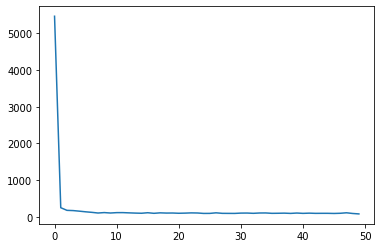

In [6]:
import matplotlib.pyplot as plt
plt.plot(range(len(losses)),losses)

In [7]:
W2.value

array([[ 5.32391589],
       [ 5.78469387],
       [ 9.08126647],
       [ 4.09137728],
       [ 5.65244826],
       [ 8.27231842],
       [ 7.22467032],
       [10.09610977],
       [10.15992052],
       [ 9.76444972]])

In [155]:
X_[0]

array([-0.41978194,  0.28482986, -1.2879095 , -0.27259857, -0.14421743,
        0.41367189, -0.12001342,  0.1402136 , -0.98284286, -0.66660821,
       -1.45900038,  0.44105193, -1.0755623 ])

In [8]:
!pip install keras

In [20]:
import tensorflow

In [21]:
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()

model.add(Dense(units=64, activation='sigmoid', input_dim=13))
model.add(Dense(units=30, activation='sigmoid', input_dim=64))
model.add(Dense(units=1))

model.compile(loss='mse',
              optimizer='sgd',
              metrics=['mse'])

Using TensorFlow backend.


In [22]:
model.fit(X_, y_, epochs=5000, batch_size=32)

Epoch 1/5000
506/506 [==============================] - 19s 37ms/step - loss: 145.2015 - mse: 145.2015
Epoch 2/5000
506/506 [==============================] - 0s 59us/step - loss: 66.7587 - mse: 66.7587
Epoch 3/5000
506/506 [==============================] - 0s 57us/step - loss: 51.2291 - mse: 51.2291
Epoch 4/5000
506/506 [==============================] - 0s 71us/step - loss: 41.4113 - mse: 41.4113
Epoch 5/5000
506/506 [==============================] - 0s 93us/step - loss: 34.1096 - mse: 34.1096
Epoch 6/5000
506/506 [==============================] - 0s 53us/step - loss: 28.0496 - mse: 28.0496
Epoch 7/5000
506/506 [==============================] - 0s 55us/step - loss: 25.2110 - mse: 25.2110
Epoch 8/5000
506/506 [==============================] - 0s 51us/step - loss: 22.8892 - mse: 22.8892
Epoch 9/5000
506/506 [==============================] - 0s 45us/step - loss: 22.2875 - mse: 22.2875
Epoch 10/5000
506/506 [==============================] - 0s 47us/step - loss: 21.3952 - mse: 21.3

506/506 [==============================] - 0s 41us/step - loss: 9.4959 - mse: 9.4959
Epoch 83/5000
506/506 [==============================] - 0s 61us/step - loss: 10.0401 - mse: 10.0401
Epoch 84/5000
506/506 [==============================] - 0s 45us/step - loss: 9.6209 - mse: 9.6209
Epoch 85/5000
506/506 [==============================] - 0s 67us/step - loss: 9.7589 - mse: 9.7589
Epoch 86/5000
506/506 [==============================] - 0s 75us/step - loss: 9.4780 - mse: 9.4780
Epoch 87/5000
506/506 [==============================] - 0s 59us/step - loss: 9.5017 - mse: 9.5017
Epoch 88/5000
506/506 [==============================] - 0s 53us/step - loss: 9.4532 - mse: 9.4532
Epoch 89/5000
506/506 [==============================] - 0s 59us/step - loss: 9.4788 - mse: 9.4788
Epoch 90/5000
506/506 [==============================] - 0s 47us/step - loss: 9.2474 - mse: 9.2474
Epoch 91/5000
506/506 [==============================] - 0s 47us/step - loss: 9.6928 - mse: 9.6928
Epoch 92/5000
506/506 

506/506 [==============================] - 0s 53us/step - loss: 6.3197 - mse: 6.3197
Epoch 165/5000
506/506 [==============================] - 0s 57us/step - loss: 6.4927 - mse: 6.4927
Epoch 166/5000
506/506 [==============================] - 0s 53us/step - loss: 6.3351 - mse: 6.3351
Epoch 167/5000
506/506 [==============================] - 0s 61us/step - loss: 6.3841 - mse: 6.3841
Epoch 168/5000
506/506 [==============================] - 0s 59us/step - loss: 6.2870 - mse: 6.2870
Epoch 169/5000
506/506 [==============================] - 0s 65us/step - loss: 6.3183 - mse: 6.3183
Epoch 170/5000
506/506 [==============================] - 0s 49us/step - loss: 6.3575 - mse: 6.3575
Epoch 171/5000
506/506 [==============================] - 0s 45us/step - loss: 6.2496 - mse: 6.2496
Epoch 172/5000
506/506 [==============================] - 0s 49us/step - loss: 6.3322 - mse: 6.3322
Epoch 173/5000
506/506 [==============================] - ETA: 0s - loss: 6.6165 - mse: 6.616 - 0s 41us/step - loss

506/506 [==============================] - 0s 40us/step - loss: 4.7945 - mse: 4.7945
Epoch 246/5000
506/506 [==============================] - 0s 45us/step - loss: 4.5654 - mse: 4.5654
Epoch 247/5000
506/506 [==============================] - 0s 47us/step - loss: 4.7470 - mse: 4.7470
Epoch 248/5000
506/506 [==============================] - 0s 93us/step - loss: 4.6438 - mse: 4.6438
Epoch 249/5000
506/506 [==============================] - 0s 83us/step - loss: 4.5859 - mse: 4.5859
Epoch 250/5000
506/506 [==============================] - 0s 87us/step - loss: 4.6629 - mse: 4.6629
Epoch 251/5000
506/506 [==============================] - 0s 95us/step - loss: 4.6284 - mse: 4.6284
Epoch 252/5000
506/506 [==============================] - 0s 49us/step - loss: 4.5389 - mse: 4.5389
Epoch 253/5000
506/506 [==============================] - 0s 47us/step - loss: 4.5943 - mse: 4.5943
Epoch 254/5000
506/506 [==============================] - 0s 53us/step - loss: 4.4862 - mse: 4.4862
Epoch 255/5000


506/506 [==============================] - 0s 41us/step - loss: 3.7125 - mse: 3.7125
Epoch 327/5000
506/506 [==============================] - 0s 41us/step - loss: 3.5861 - mse: 3.5861
Epoch 328/5000
506/506 [==============================] - 0s 41us/step - loss: 3.5661 - mse: 3.5661
Epoch 329/5000
506/506 [==============================] - 0s 55us/step - loss: 3.6739 - mse: 3.6739
Epoch 330/5000
506/506 [==============================] - 0s 40us/step - loss: 3.6372 - mse: 3.6372
Epoch 331/5000
506/506 [==============================] - 0s 49us/step - loss: 3.6604 - mse: 3.6604
Epoch 332/5000
506/506 [==============================] - 0s 41us/step - loss: 3.5451 - mse: 3.5451
Epoch 333/5000
506/506 [==============================] - 0s 47us/step - loss: 3.5266 - mse: 3.5266
Epoch 334/5000
506/506 [==============================] - 0s 49us/step - loss: 3.5178 - mse: 3.5178
Epoch 335/5000
506/506 [==============================] - 0s 47us/step - loss: 3.5552 - mse: 3.5552
Epoch 336/5000


506/506 [==============================] - 0s 47us/step - loss: 2.9759 - mse: 2.9759
Epoch 409/5000
506/506 [==============================] - 0s 53us/step - loss: 2.9640 - mse: 2.9640
Epoch 410/5000
506/506 [==============================] - 0s 49us/step - loss: 3.2482 - mse: 3.2482
Epoch 411/5000
506/506 [==============================] - 0s 53us/step - loss: 2.9161 - mse: 2.9161
Epoch 412/5000
506/506 [==============================] - 0s 47us/step - loss: 2.9197 - mse: 2.9197
Epoch 413/5000
506/506 [==============================] - 0s 43us/step - loss: 2.9462 - mse: 2.9462
Epoch 414/5000
506/506 [==============================] - 0s 47us/step - loss: 2.9217 - mse: 2.9217
Epoch 415/5000
506/506 [==============================] - 0s 45us/step - loss: 2.8897 - mse: 2.8897
Epoch 416/5000
506/506 [==============================] - 0s 43us/step - loss: 2.9082 - mse: 2.9082
Epoch 417/5000
506/506 [==============================] - 0s 49us/step - loss: 3.1398 - mse: 3.1398
Epoch 418/5000


506/506 [==============================] - 0s 40us/step - loss: 2.6123 - mse: 2.6123
Epoch 490/5000
506/506 [==============================] - 0s 40us/step - loss: 2.6497 - mse: 2.6497
Epoch 491/5000
506/506 [==============================] - 0s 59us/step - loss: 2.5545 - mse: 2.5545
Epoch 492/5000
506/506 [==============================] - 0s 40us/step - loss: 2.6518 - mse: 2.6518
Epoch 493/5000
506/506 [==============================] - 0s 40us/step - loss: 2.5801 - mse: 2.5801
Epoch 494/5000
506/506 [==============================] - 0s 40us/step - loss: 2.5120 - mse: 2.5120
Epoch 495/5000
506/506 [==============================] - 0s 40us/step - loss: 2.5044 - mse: 2.5044
Epoch 496/5000
506/506 [==============================] - 0s 40us/step - loss: 2.6665 - mse: 2.6665
Epoch 497/5000
506/506 [==============================] - 0s 40us/step - loss: 2.6022 - mse: 2.6022
Epoch 498/5000
506/506 [==============================] - 0s 59us/step - loss: 2.5203 - mse: 2.5203
Epoch 499/5000


506/506 [==============================] - 0s 59us/step - loss: 2.2940 - mse: 2.2940
Epoch 572/5000
506/506 [==============================] - 0s 40us/step - loss: 2.2870 - mse: 2.2870
Epoch 573/5000
506/506 [==============================] - 0s 40us/step - loss: 2.3607 - mse: 2.3607
Epoch 574/5000
506/506 [==============================] - 0s 40us/step - loss: 2.2817 - mse: 2.2817
Epoch 575/5000
506/506 [==============================] - 0s 40us/step - loss: 2.2919 - mse: 2.2919
Epoch 576/5000
506/506 [==============================] - 0s 40us/step - loss: 2.3029 - mse: 2.3029
Epoch 577/5000
506/506 [==============================] - 0s 40us/step - loss: 2.2666 - mse: 2.2666
Epoch 578/5000
506/506 [==============================] - 0s 40us/step - loss: 2.3201 - mse: 2.3201
Epoch 579/5000
506/506 [==============================] - 0s 40us/step - loss: 2.2926 - mse: 2.2926
Epoch 580/5000
506/506 [==============================] - ETA: 0s - loss: 1.7468 - mse: 1.746 - 0s 40us/step - loss

506/506 [==============================] - 0s 40us/step - loss: 2.1202 - mse: 2.1202
Epoch 653/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1602 - mse: 2.1602
Epoch 654/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1170 - mse: 2.1170
Epoch 655/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1576 - mse: 2.1576
Epoch 656/5000
506/506 [==============================] - 0s 59us/step - loss: 2.0840 - mse: 2.0840
Epoch 657/5000
506/506 [==============================] - 0s 40us/step - loss: 2.0685 - mse: 2.0685
Epoch 658/5000
506/506 [==============================] - 0s 40us/step - loss: 2.0970 - mse: 2.0970
Epoch 659/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1119 - mse: 2.1119
Epoch 660/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1025 - mse: 2.1025
Epoch 661/5000
506/506 [==============================] - 0s 40us/step - loss: 2.1219 - mse: 2.1219
Epoch 662/5000


506/506 [==============================] - 0s 40us/step - loss: 1.9573 - mse: 1.9573
Epoch 735/5000
506/506 [==============================] - 0s 59us/step - loss: 1.9680 - mse: 1.9680
Epoch 736/5000
506/506 [==============================] - 0s 40us/step - loss: 1.8907 - mse: 1.8907
Epoch 737/5000
506/506 [==============================] - 0s 59us/step - loss: 1.9943 - mse: 1.9943
Epoch 738/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9723 - mse: 1.9723
Epoch 739/5000
506/506 [==============================] - 0s 59us/step - loss: 1.9315 - mse: 1.9315
Epoch 740/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9201 - mse: 1.9201
Epoch 741/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9795 - mse: 1.9795
Epoch 742/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9395 - mse: 1.9395
Epoch 743/5000
506/506 [==============================] - 0s 40us/step - loss: 1.9469 - mse: 1.9469
Epoch 744/5000


506/506 [==============================] - 0s 40us/step - loss: 1.8170 - mse: 1.8170
Epoch 817/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7792 - mse: 1.7792
Epoch 818/5000
506/506 [==============================] - 0s 40us/step - loss: 1.8506 - mse: 1.8506
Epoch 819/5000
506/506 [==============================] - 0s 59us/step - loss: 1.8427 - mse: 1.8427
Epoch 820/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7846 - mse: 1.7846
Epoch 821/5000
506/506 [==============================] - 0s 59us/step - loss: 1.8173 - mse: 1.8173
Epoch 822/5000
506/506 [==============================] - 0s 40us/step - loss: 1.8312 - mse: 1.8312
Epoch 823/5000
506/506 [==============================] - 0s 59us/step - loss: 1.8141 - mse: 1.8141
Epoch 824/5000
506/506 [==============================] - 0s 59us/step - loss: 1.7885 - mse: 1.7885
Epoch 825/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7810 - mse: 1.7810
Epoch 826/5000


506/506 [==============================] - 0s 40us/step - loss: 1.8079 - mse: 1.8079
Epoch 899/5000
506/506 [==============================] - 0s 40us/step - loss: 1.6991 - mse: 1.6991
Epoch 900/5000
506/506 [==============================] - 0s 59us/step - loss: 1.7068 - mse: 1.7068
Epoch 901/5000
506/506 [==============================] - 0s 56us/step - loss: 1.6862 - mse: 1.6862
Epoch 902/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7275 - mse: 1.7275
Epoch 903/5000
506/506 [==============================] - 0s 40us/step - loss: 1.6958 - mse: 1.6958
Epoch 904/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7435 - mse: 1.7435
Epoch 905/5000
506/506 [==============================] - 0s 59us/step - loss: 1.7227 - mse: 1.7227
Epoch 906/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7182 - mse: 1.7182
Epoch 907/5000
506/506 [==============================] - 0s 59us/step - loss: 1.7507 - mse: 1.7507
Epoch 908/5000


506/506 [==============================] - 0s 59us/step - loss: 1.5933 - mse: 1.5933
Epoch 980/5000
506/506 [==============================] - 0s 40us/step - loss: 1.7039 - mse: 1.7039
Epoch 981/5000
506/506 [==============================] - 0s 59us/step - loss: 1.5710 - mse: 1.5710
Epoch 982/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5857 - mse: 1.5857
Epoch 983/5000
506/506 [==============================] - 0s 59us/step - loss: 1.6364 - mse: 1.6364
Epoch 984/5000
506/506 [==============================] - 0s 40us/step - loss: 1.6073 - mse: 1.6073
Epoch 985/5000
506/506 [==============================] - 0s 40us/step - loss: 1.6199 - mse: 1.6199
Epoch 986/5000
506/506 [==============================] - 0s 40us/step - loss: 1.6289 - mse: 1.6289
Epoch 987/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5809 - mse: 1.5809
Epoch 988/5000
506/506 [==============================] - 0s 59us/step - loss: 1.6162 - mse: 1.6162
Epoch 989/5000


506/506 [==============================] - 0s 40us/step - loss: 1.5299 - mse: 1.5299
Epoch 1061/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5036 - mse: 1.5036
Epoch 1062/5000
506/506 [==============================] - 0s 59us/step - loss: 1.5690 - mse: 1.5690
Epoch 1063/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5381 - mse: 1.5381
Epoch 1064/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4819 - mse: 1.4819
Epoch 1065/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4736 - mse: 1.4736
Epoch 1066/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5211 - mse: 1.5211
Epoch 1067/5000
506/506 [==============================] - 0s 59us/step - loss: 1.6044 - mse: 1.6044
Epoch 1068/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4967 - mse: 1.4967
Epoch 1069/5000
506/506 [==============================] - 0s 40us/step - loss: 1.5206 - mse: 1.5206
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.4426 - mse: 1.4426
Epoch 1141/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4754 - mse: 1.4754
Epoch 1142/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4280 - mse: 1.4280
Epoch 1143/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4196 - mse: 1.4196
Epoch 1144/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4084 - mse: 1.4084
Epoch 1145/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4178 - mse: 1.4178
Epoch 1146/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4271 - mse: 1.4271
Epoch 1147/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4329 - mse: 1.4329
Epoch 1148/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4851 - mse: 1.4851
Epoch 1149/5000
506/506 [==============================] - 0s 59us/step - loss: 1.4363 - mse: 1.4363
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 1.3639 - mse: 1.3639
Epoch 1222/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3317 - mse: 1.3317
Epoch 1223/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3416 - mse: 1.3416
Epoch 1224/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3388 - mse: 1.3388
Epoch 1225/5000
506/506 [==============================] - 0s 59us/step - loss: 1.3455 - mse: 1.3455
Epoch 1226/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3347 - mse: 1.3347
Epoch 1227/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3245 - mse: 1.3245
Epoch 1228/5000
506/506 [==============================] - 0s 59us/step - loss: 1.3324 - mse: 1.3324
Epoch 1229/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3355 - mse: 1.3355
Epoch 1230/5000
506/506 [==============================] - 0s 40us/step - loss: 1.4630 - mse: 1.4630
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.2735 - mse: 1.2735
Epoch 1303/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2429 - mse: 1.2429
Epoch 1304/5000
506/506 [==============================] - 0s 20us/step - loss: 1.2854 - mse: 1.2854
Epoch 1305/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2913 - mse: 1.2913
Epoch 1306/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3190 - mse: 1.3190
Epoch 1307/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3049 - mse: 1.3049
Epoch 1308/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2878 - mse: 1.2878
Epoch 1309/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2374 - mse: 1.2374
Epoch 1310/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2763 - mse: 1.2763
Epoch 1311/5000
506/506 [==============================] - 0s 59us/step - loss: 1.2744 - mse: 1.2744
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.2161 - mse: 1.2161
Epoch 1384/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2454 - mse: 1.2454
Epoch 1385/5000
506/506 [==============================] - 0s 40us/step - loss: 1.3347 - mse: 1.3347
Epoch 1386/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1835 - mse: 1.1835
Epoch 1387/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1846 - mse: 1.1846
Epoch 1388/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1840 - mse: 1.1840
Epoch 1389/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2004 - mse: 1.2004
Epoch 1390/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2048 - mse: 1.2048
Epoch 1391/5000
506/506 [==============================] - 0s 40us/step - loss: 1.2298 - mse: 1.2298
Epoch 1392/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1893 - mse: 1.1893
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.1781 - mse: 1.1781
Epoch 1465/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1325 - mse: 1.1325
Epoch 1466/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1663 - mse: 1.1663
Epoch 1467/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1695 - mse: 1.1695
Epoch 1468/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1030 - mse: 1.1030
Epoch 1469/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1239 - mse: 1.1239
Epoch 1470/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1173 - mse: 1.1173
Epoch 1471/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0918 - mse: 1.0918
Epoch 1472/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1621 - mse: 1.1621
Epoch 1473/5000
506/506 [==============================] - 0s 40us/step - loss: 1.1266 - mse: 1.1266
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.0857 - mse: 1.0857
Epoch 1546/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0750 - mse: 1.0750
Epoch 1547/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0770 - mse: 1.0770
Epoch 1548/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0364 - mse: 1.0364
Epoch 1549/5000
506/506 [==============================] - 0s 59us/step - loss: 1.0820 - mse: 1.0820
Epoch 1550/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0689 - mse: 1.0689
Epoch 1551/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0539 - mse: 1.0539
Epoch 1552/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0681 - mse: 1.0681
Epoch 1553/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0538 - mse: 1.0538
Epoch 1554/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0432 - mse: 1.0432
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 1.0766 - mse: 1.0766
Epoch 1627/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9998 - mse: 0.9998
Epoch 1628/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9920 - mse: 0.9920
Epoch 1629/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0196 - mse: 1.0196
Epoch 1630/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0124 - mse: 1.0124
Epoch 1631/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0038 - mse: 1.0038
Epoch 1632/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0721 - mse: 1.0721
Epoch 1633/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9986 - mse: 0.9986
Epoch 1634/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9860 - mse: 0.9860
Epoch 1635/5000
506/506 [==============================] - 0s 40us/step - loss: 1.0254 - mse: 1.0254
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.9660 - mse: 0.9660
Epoch 1707/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9478 - mse: 0.9478
Epoch 1708/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9596 - mse: 0.9596
Epoch 1709/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9642 - mse: 0.9642
Epoch 1710/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9361 - mse: 0.9361
Epoch 1711/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9546 - mse: 0.9546
Epoch 1712/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9604 - mse: 0.9604
Epoch 1713/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9516 - mse: 0.9516
Epoch 1714/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9412 - mse: 0.9412
Epoch 1715/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9914 - mse: 0.9914
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.9237 - mse: 0.9237
Epoch 1787/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9166 - mse: 0.9166
Epoch 1788/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9457 - mse: 0.9457
Epoch 1789/5000
506/506 [==============================] - 0s 20us/step - loss: 0.9100 - mse: 0.9100
Epoch 1790/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9037 - mse: 0.9037
Epoch 1791/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9418 - mse: 0.9418
Epoch 1792/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9423 - mse: 0.9423
Epoch 1793/5000
506/506 [==============================] - 0s 59us/step - loss: 0.9329 - mse: 0.9329
Epoch 1794/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9337 - mse: 0.9337
Epoch 1795/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9063 - mse: 0.9063
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.8560 - mse: 0.8560
Epoch 1868/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8965 - mse: 0.8965
Epoch 1869/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9038 - mse: 0.9038
Epoch 1870/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8840 - mse: 0.8840
Epoch 1871/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8834 - mse: 0.8834
Epoch 1872/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9114 - mse: 0.9114
Epoch 1873/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8507 - mse: 0.8507
Epoch 1874/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9145 - mse: 0.9145
Epoch 1875/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8569 - mse: 0.8569
Epoch 1876/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8679 - mse: 0.8679
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.8463 - mse: 0.8463
Epoch 1949/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8518 - mse: 0.8518
Epoch 1950/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8263 - mse: 0.8263
Epoch 1951/5000
506/506 [==============================] - 0s 40us/step - loss: 0.9256 - mse: 0.9256
Epoch 1952/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8160 - mse: 0.8160
Epoch 1953/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8479 - mse: 0.8479
Epoch 1954/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8358 - mse: 0.8358
Epoch 1955/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8259 - mse: 0.8259
Epoch 1956/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8375 - mse: 0.8375
Epoch 1957/5000
506/506 [==============================] - 0s 59us/step - loss: 0.7922 - mse: 0.7922
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.7923 - mse: 0.7923
Epoch 2030/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8045 - mse: 0.8045
Epoch 2031/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8116 - mse: 0.8116
Epoch 2032/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7824 - mse: 0.7824
Epoch 2033/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7881 - mse: 0.7881
Epoch 2034/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8485 - mse: 0.8485
Epoch 2035/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8183 - mse: 0.8183
Epoch 2036/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8066 - mse: 0.8066
Epoch 2037/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8129 - mse: 0.8129
Epoch 2038/5000
506/506 [==============================] - 0s 40us/step - loss: 0.8058 - mse: 0.8058
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.7470 - mse: 0.7470
Epoch 2111/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7464 - mse: 0.7464
Epoch 2112/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7585 - mse: 0.7585
Epoch 2113/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7513 - mse: 0.7513
Epoch 2114/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7373 - mse: 0.7373
Epoch 2115/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7571 - mse: 0.7571
Epoch 2116/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7640 - mse: 0.7640
Epoch 2117/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7554 - mse: 0.7554
Epoch 2118/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7527 - mse: 0.7527
Epoch 2119/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7780 - mse: 0.7780
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.7308 - mse: 0.7308
Epoch 2192/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7030 - mse: 0.7030
Epoch 2193/5000
506/506 [==============================] - 0s 59us/step - loss: 0.7284 - mse: 0.7284
Epoch 2194/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7008 - mse: 0.7008
Epoch 2195/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7363 - mse: 0.7363
Epoch 2196/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7506 - mse: 0.7506
Epoch 2197/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7299 - mse: 0.7299
Epoch 2198/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6910 - mse: 0.6910
Epoch 2199/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7569 - mse: 0.7569
Epoch 2200/5000
506/506 [==============================] - 0s 40us/step - loss: 0.7055 - mse: 0.7055
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.6839 - mse: 0.6839
Epoch 2272/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6882 - mse: 0.6882
Epoch 2273/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6979 - mse: 0.6979
Epoch 2274/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6843 - mse: 0.6843
Epoch 2275/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6951 - mse: 0.6951
Epoch 2276/5000
506/506 [==============================] - 0s 20us/step - loss: 0.6607 - mse: 0.6607
Epoch 2277/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6894 - mse: 0.6894
Epoch 2278/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6579 - mse: 0.6579
Epoch 2279/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6639 - mse: 0.6639
Epoch 2280/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6682 - mse: 0.6682
Epoch 

506/506 [==============================] - 0s 79us/step - loss: 0.7080 - mse: 0.7080
Epoch 2353/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6467 - mse: 0.6467
Epoch 2354/5000
506/506 [==============================] - 0s 59us/step - loss: 0.7018 - mse: 0.7018
Epoch 2355/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6759 - mse: 0.6759
Epoch 2356/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6516 - mse: 0.6516
Epoch 2357/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6462 - mse: 0.6462
Epoch 2358/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6460 - mse: 0.6460
Epoch 2359/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6671 - mse: 0.6671
Epoch 2360/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6580 - mse: 0.6580
Epoch 2361/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6267 - mse: 0.6267
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5915 - mse: 0.5915
Epoch 2434/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6286 - mse: 0.6286
Epoch 2435/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6414 - mse: 0.6414
Epoch 2436/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6440 - mse: 0.6440
Epoch 2437/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6524 - mse: 0.6524
Epoch 2438/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6346 - mse: 0.6346
Epoch 2439/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6321 - mse: 0.6321
Epoch 2440/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6382 - mse: 0.6382
Epoch 2441/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6241 - mse: 0.6241
Epoch 2442/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6178 - mse: 0.6178
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.6176 - mse: 0.6176
Epoch 2514/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6340 - mse: 0.6340
Epoch 2515/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6008 - mse: 0.6008
Epoch 2516/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6513 - mse: 0.6513
Epoch 2517/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5985 - mse: 0.5985
Epoch 2518/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6329 - mse: 0.6329
Epoch 2519/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5818 - mse: 0.5818
Epoch 2520/5000
506/506 [==============================] - 0s 59us/step - loss: 0.6034 - mse: 0.6034
Epoch 2521/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5946 - mse: 0.5946
Epoch 2522/5000
506/506 [==============================] - 0s 40us/step - loss: 0.6025 - mse: 0.6025
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5962 - mse: 0.5962
Epoch 2595/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5560 - mse: 0.5560
Epoch 2596/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5638 - mse: 0.5638
Epoch 2597/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5612 - mse: 0.5612
Epoch 2598/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5743 - mse: 0.5743
Epoch 2599/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5628 - mse: 0.5628
Epoch 2600/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5794 - mse: 0.5794
Epoch 2601/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5981 - mse: 0.5981
Epoch 2602/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5527 - mse: 0.5527
Epoch 2603/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5718 - mse: 0.5718
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5468 - mse: 0.5468
Epoch 2676/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5443 - mse: 0.5443
Epoch 2677/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5288 - mse: 0.5288
Epoch 2678/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5634 - mse: 0.5634
Epoch 2679/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5559 - mse: 0.5559
Epoch 2680/5000
506/506 [==============================] - 0s 59us/step - loss: 0.5414 - mse: 0.5414
Epoch 2681/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5351 - mse: 0.5351
Epoch 2682/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5342 - mse: 0.5342
Epoch 2683/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5406 - mse: 0.5406
Epoch 2684/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5696 - mse: 0.5696
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5151 - mse: 0.5151
Epoch 2756/5000
506/506 [==============================] - 0s 59us/step - loss: 0.5033 - mse: 0.5033
Epoch 2757/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5057 - mse: 0.5057
Epoch 2758/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5177 - mse: 0.5177
Epoch 2759/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5384 - mse: 0.5384
Epoch 2760/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4937 - mse: 0.4937
Epoch 2761/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5361 - mse: 0.5361
Epoch 2762/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5581 - mse: 0.5581
Epoch 2763/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5417 - mse: 0.5417
Epoch 2764/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5224 - mse: 0.5224
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5094 - mse: 0.5094
Epoch 2837/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4918 - mse: 0.4918
Epoch 2838/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4918 - mse: 0.4918
Epoch 2839/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4753 - mse: 0.4753
Epoch 2840/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4926 - mse: 0.4926
Epoch 2841/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5052 - mse: 0.5052
Epoch 2842/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4960 - mse: 0.4960
Epoch 2843/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4906 - mse: 0.4906
Epoch 2844/5000
506/506 [==============================] - 0s 40us/step - loss: 0.5176 - mse: 0.5176
Epoch 2845/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4829 - mse: 0.4829
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.5690 - mse: 0.5690
Epoch 2917/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4627 - mse: 0.4627
Epoch 2918/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4739 - mse: 0.4739
Epoch 2919/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4603 - mse: 0.4603
Epoch 2920/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4695 - mse: 0.4695
Epoch 2921/5000
506/506 [==============================] - 0s 59us/step - loss: 0.4440 - mse: 0.4440
Epoch 2922/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4833 - mse: 0.4833
Epoch 2923/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4893 - mse: 0.4893
Epoch 2924/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4796 - mse: 0.4796
Epoch 2925/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4708 - mse: 0.4708
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.4756 - mse: 0.4756
Epoch 2998/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4689 - mse: 0.4689
Epoch 2999/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4443 - mse: 0.4443
Epoch 3000/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4401 - mse: 0.4401
Epoch 3001/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4560 - mse: 0.4560
Epoch 3002/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4667 - mse: 0.4667
Epoch 3003/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4583 - mse: 0.4583
Epoch 3004/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4243 - mse: 0.4243
Epoch 3005/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4360 - mse: 0.4360
Epoch 3006/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4398 - mse: 0.4398
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.4291 - mse: 0.4291
Epoch 3078/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4571 - mse: 0.4571
Epoch 3079/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4468 - mse: 0.4468
Epoch 3080/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4235 - mse: 0.4235
Epoch 3081/5000
506/506 [==============================] - 0s 59us/step - loss: 0.4182 - mse: 0.4182
Epoch 3082/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4048 - mse: 0.4048
Epoch 3083/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4232 - mse: 0.4232
Epoch 3084/5000
506/506 [==============================] - 0s 59us/step - loss: 0.4419 - mse: 0.4419
Epoch 3085/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4585 - mse: 0.4585
Epoch 3086/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4321 - mse: 0.4321
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.4058 - mse: 0.4058
Epoch 3159/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4006 - mse: 0.4006
Epoch 3160/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4304 - mse: 0.4304
Epoch 3161/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4376 - mse: 0.4376
Epoch 3162/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4108 - mse: 0.4108
Epoch 3163/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3870 - mse: 0.3870
Epoch 3164/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4132 - mse: 0.4132
Epoch 3165/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4156 - mse: 0.4156
Epoch 3166/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4025 - mse: 0.4025
Epoch 3167/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3974 - mse: 0.3974
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 0.3876 - mse: 0.3876
Epoch 3240/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3932 - mse: 0.3932
Epoch 3241/5000
506/506 [==============================] - 0s 59us/step - loss: 0.3805 - mse: 0.3805
Epoch 3242/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3787 - mse: 0.3787
Epoch 3243/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4056 - mse: 0.4056
Epoch 3244/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3822 - mse: 0.3822
Epoch 3245/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3885 - mse: 0.3885
Epoch 3246/5000
506/506 [==============================] - 0s 40us/step - loss: 0.4000 - mse: 0.4000
Epoch 3247/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3826 - mse: 0.3826
Epoch 3248/5000
506/506 [==============================] - 0s 59us/step - loss: 0.4122 - mse: 0.4122
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 0.3895 - mse: 0.3895
Epoch 3321/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3674 - mse: 0.3674
Epoch 3322/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3752 - mse: 0.3752
Epoch 3323/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3694 - mse: 0.3694
Epoch 3324/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3435 - mse: 0.3435
Epoch 3325/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3880 - mse: 0.3880
Epoch 3326/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3653 - mse: 0.3653
Epoch 3327/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3604 - mse: 0.3604
Epoch 3328/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3799 - mse: 0.3799
Epoch 3329/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3501 - mse: 0.3501
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.3583 - mse: 0.3583
Epoch 3401/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3393 - mse: 0.3393
Epoch 3402/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3507 - mse: 0.3507
Epoch 3403/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3601 - mse: 0.3601
Epoch 3404/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3485 - mse: 0.3485
Epoch 3405/5000
506/506 [==============================] - 0s 59us/step - loss: 0.3383 - mse: 0.3383
Epoch 3406/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3462 - mse: 0.3462
Epoch 3407/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3325 - mse: 0.3325
Epoch 3408/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3721 - mse: 0.3721
Epoch 3409/5000
506/506 [==============================] - 0s 20us/step - loss: 0.3454 - mse: 0.3454
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.3481 - mse: 0.3481
Epoch 3482/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3472 - mse: 0.3472
Epoch 3483/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3256 - mse: 0.3256
Epoch 3484/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3125 - mse: 0.3125
Epoch 3485/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3583 - mse: 0.3583
Epoch 3486/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3552 - mse: 0.3552
Epoch 3487/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3323 - mse: 0.3323
Epoch 3488/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3354 - mse: 0.3354
Epoch 3489/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3533 - mse: 0.3533
Epoch 3490/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3194 - mse: 0.3194
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.3233 - mse: 0.3233
Epoch 3562/5000
506/506 [==============================] - ETA: 0s - loss: 0.2180 - mse: 0.218 - 0s 79us/step - loss: 0.3107 - mse: 0.3107
Epoch 3563/5000
506/506 [==============================] - 0s 79us/step - loss: 0.3079 - mse: 0.3079
Epoch 3564/5000
506/506 [==============================] - 0s 79us/step - loss: 0.3059 - mse: 0.3059
Epoch 3565/5000
506/506 [==============================] - 0s 79us/step - loss: 0.3114 - mse: 0.3114
Epoch 3566/5000
506/506 [==============================] - 0s 99us/step - loss: 0.3064 - mse: 0.3064
Epoch 3567/5000
506/506 [==============================] - 0s 99us/step - loss: 0.3239 - mse: 0.3239
Epoch 3568/5000
506/506 [==============================] - 0s 59us/step - loss: 0.3172 - mse: 0.3172
Epoch 3569/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3174 - mse: 0.3174
Epoch 3570/5000
506/506 [==============================] - 0s 40us/st

506/506 [==============================] - 0s 40us/step - loss: 0.2998 - mse: 0.2998
Epoch 3642/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2879 - mse: 0.2879
Epoch 3643/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3179 - mse: 0.3179
Epoch 3644/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3002 - mse: 0.3002
Epoch 3645/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2877 - mse: 0.2877
Epoch 3646/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2966 - mse: 0.2966
Epoch 3647/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2993 - mse: 0.2993
Epoch 3648/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2922 - mse: 0.2922
Epoch 3649/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2969 - mse: 0.2969
Epoch 3650/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2970 - mse: 0.2970
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.2751 - mse: 0.2751
Epoch 3723/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2746 - mse: 0.2746
Epoch 3724/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2948 - mse: 0.2948
Epoch 3725/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2924 - mse: 0.2924
Epoch 3726/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2820 - mse: 0.2820
Epoch 3727/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2889 - mse: 0.2889
Epoch 3728/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2843 - mse: 0.2843
Epoch 3729/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2699 - mse: 0.2699
Epoch 3730/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2623 - mse: 0.2623
Epoch 3731/5000
506/506 [==============================] - 0s 40us/step - loss: 0.3002 - mse: 0.3002
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.2773 - mse: 0.2773
Epoch 3804/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2828 - mse: 0.2828
Epoch 3805/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2729 - mse: 0.2729
Epoch 3806/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2912 - mse: 0.2912
Epoch 3807/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2674 - mse: 0.2674
Epoch 3808/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2676 - mse: 0.2676
Epoch 3809/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2780 - mse: 0.2780
Epoch 3810/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2905 - mse: 0.2905
Epoch 3811/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2667 - mse: 0.2667
Epoch 3812/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2725 - mse: 0.2725
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 0.2536 - mse: 0.2536
Epoch 3885/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2690 - mse: 0.2690
Epoch 3886/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2676 - mse: 0.2676
Epoch 3887/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2648 - mse: 0.2648
Epoch 3888/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2554 - mse: 0.2554
Epoch 3889/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2816 - mse: 0.2816
Epoch 3890/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2583 - mse: 0.2583
Epoch 3891/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2586 - mse: 0.2586
Epoch 3892/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2706 - mse: 0.2706
Epoch 3893/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2408 - mse: 0.2408
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 0.2435 - mse: 0.2435
Epoch 3966/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2449 - mse: 0.2449
Epoch 3967/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2646 - mse: 0.2646
Epoch 3968/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2386 - mse: 0.2386
Epoch 3969/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2383 - mse: 0.2383
Epoch 3970/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2478 - mse: 0.2478
Epoch 3971/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2430 - mse: 0.2430
Epoch 3972/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2451 - mse: 0.2451
Epoch 3973/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2445 - mse: 0.2445
Epoch 3974/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2731 - mse: 0.2731
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.2366 - mse: 0.2366
Epoch 4046/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2520 - mse: 0.2520
Epoch 4047/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2515 - mse: 0.2515
Epoch 4048/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2485 - mse: 0.2485
Epoch 4049/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2611 - mse: 0.2611
Epoch 4050/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2279 - mse: 0.2279
Epoch 4051/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2255 - mse: 0.2255
Epoch 4052/5000
506/506 [==============================] - 0s 79us/step - loss: 0.2180 - mse: 0.2180
Epoch 4053/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2201 - mse: 0.2201
Epoch 4054/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2446 - mse: 0.2446
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.2141 - mse: 0.2141
Epoch 4127/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2188 - mse: 0.2188
Epoch 4128/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2258 - mse: 0.2258
Epoch 4129/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2133 - mse: 0.2133
Epoch 4130/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2338 - mse: 0.2338
Epoch 4131/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2228 - mse: 0.2228
Epoch 4132/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2249 - mse: 0.2249
Epoch 4133/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2235 - mse: 0.2235
Epoch 4134/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2108 - mse: 0.2108
Epoch 4135/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2240 - mse: 0.2240
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.2070 - mse: 0.2070
Epoch 4207/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2033 - mse: 0.2033
Epoch 4208/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2119 - mse: 0.2119
Epoch 4209/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2038 - mse: 0.2038
Epoch 4210/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2003 - mse: 0.2003
Epoch 4211/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2226 - mse: 0.2226
Epoch 4212/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2053 - mse: 0.2053
Epoch 4213/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2249 - mse: 0.2249
Epoch 4214/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2311 - mse: 0.2311
Epoch 4215/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2120 - mse: 0.2120
Epoch 

506/506 [==============================] - 0s 99us/step - loss: 0.2365 - mse: 0.2365
Epoch 4288/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1955 - mse: 0.1955
Epoch 4289/5000
506/506 [==============================] - 0s 79us/step - loss: 0.2151 - mse: 0.2151
Epoch 4290/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1925 - mse: 0.1925
Epoch 4291/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2071 - mse: 0.2071
Epoch 4292/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1915 - mse: 0.1915
Epoch 4293/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1979 - mse: 0.1979
Epoch 4294/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2030 - mse: 0.2030
Epoch 4295/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2091 - mse: 0.2091
Epoch 4296/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1978 - mse: 0.1978
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.1926 - mse: 0.1926
Epoch 4369/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1940 - mse: 0.1940
Epoch 4370/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1922 - mse: 0.1922
Epoch 4371/5000
506/506 [==============================] - 0s 79us/step - loss: 0.1939 - mse: 0.1939
Epoch 4372/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1939 - mse: 0.1939
Epoch 4373/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1902 - mse: 0.1902
Epoch 4374/5000
506/506 [==============================] - 0s 99us/step - loss: 0.1965 - mse: 0.1965
Epoch 4375/5000
506/506 [==============================] - 0s 99us/step - loss: 0.1926 - mse: 0.1926
Epoch 4376/5000
506/506 [==============================] - 0s 138us/step - loss: 0.1846 - mse: 0.1846
Epoch 4377/5000
506/506 [==============================] - 0s 40us/step - loss: 0.2071 - mse: 0.2071
Epoch

506/506 [==============================] - 0s 59us/step - loss: 0.1823 - mse: 0.1823
Epoch 4450/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1892 - mse: 0.1892
Epoch 4451/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1714 - mse: 0.1714
Epoch 4452/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1787 - mse: 0.1787
Epoch 4453/5000
506/506 [==============================] - 0s 59us/step - loss: 0.2067 - mse: 0.2067
Epoch 4454/5000
506/506 [==============================] - 0s 99us/step - loss: 0.1908 - mse: 0.1908
Epoch 4455/5000
506/506 [==============================] - 0s 79us/step - loss: 0.1925 - mse: 0.1925
Epoch 4456/5000
506/506 [==============================] - 0s 119us/step - loss: 0.1761 - mse: 0.1761
Epoch 4457/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1781 - mse: 0.1781
Epoch 4458/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1782 - mse: 0.1782
Epoch

506/506 [==============================] - 0s 40us/step - loss: 0.1741 - mse: 0.1741
Epoch 4530/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1689 - mse: 0.1689
Epoch 4531/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1764 - mse: 0.1764
Epoch 4532/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1845 - mse: 0.1845
Epoch 4533/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1665 - mse: 0.1665
Epoch 4534/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1597 - mse: 0.1597
Epoch 4535/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1659 - mse: 0.1659
Epoch 4536/5000
506/506 [==============================] - ETA: 0s - loss: 0.0849 - mse: 0.084 - 0s 40us/step - loss: 0.1714 - mse: 0.1714
Epoch 4537/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1733 - mse: 0.1733
Epoch 4538/5000
506/506 [==============================] - 0s 40us/st

506/506 [==============================] - 0s 40us/step - loss: 0.1599 - mse: 0.1599
Epoch 4610/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1619 - mse: 0.1619
Epoch 4611/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1569 - mse: 0.1569
Epoch 4612/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1624 - mse: 0.1624
Epoch 4613/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1677 - mse: 0.1677
Epoch 4614/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1617 - mse: 0.1617
Epoch 4615/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1719 - mse: 0.1719
Epoch 4616/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1688 - mse: 0.1688
Epoch 4617/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1658 - mse: 0.1658
Epoch 4618/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1621 - mse: 0.1621
Epoch 

506/506 [==============================] - 0s 59us/step - loss: 0.1714 - mse: 0.1714
Epoch 4690/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1662 - mse: 0.1662
Epoch 4691/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1649 - mse: 0.1649
Epoch 4692/5000
506/506 [==============================] - 0s 20us/step - loss: 0.1612 - mse: 0.1612
Epoch 4693/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1512 - mse: 0.1512
Epoch 4694/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1549 - mse: 0.1549
Epoch 4695/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1632 - mse: 0.1632
Epoch 4696/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1536 - mse: 0.1536
Epoch 4697/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1504 - mse: 0.1504
Epoch 4698/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1553 - mse: 0.1553
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.1607 - mse: 0.1607
Epoch 4771/5000
506/506 [==============================] - 0s 59us/step - loss: 0.1467 - mse: 0.1467
Epoch 4772/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1405 - mse: 0.1405
Epoch 4773/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1558 - mse: 0.1558
Epoch 4774/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1526 - mse: 0.1526
Epoch 4775/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1503 - mse: 0.1503
Epoch 4776/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1507 - mse: 0.1507
Epoch 4777/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1415 - mse: 0.1415
Epoch 4778/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1539 - mse: 0.1539
Epoch 4779/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1476 - mse: 0.1476
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.1568 - mse: 0.1568
Epoch 4852/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1421 - mse: 0.1421
Epoch 4853/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1592 - mse: 0.1592
Epoch 4854/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1514 - mse: 0.1514
Epoch 4855/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1398 - mse: 0.1398
Epoch 4856/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1493 - mse: 0.1493
Epoch 4857/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1444 - mse: 0.1444
Epoch 4858/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1495 - mse: 0.1495
Epoch 4859/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1327 - mse: 0.1327
Epoch 4860/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1482 - mse: 0.1482
Epoch 

506/506 [==============================] - 0s 40us/step - loss: 0.1466 - mse: 0.1466
Epoch 4932/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1367 - mse: 0.1367
Epoch 4933/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1432 - mse: 0.1432
Epoch 4934/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1371 - mse: 0.1371
Epoch 4935/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1315 - mse: 0.1315
Epoch 4936/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1350 - mse: 0.1350
Epoch 4937/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1340 - mse: 0.1340
Epoch 4938/5000
506/506 [==============================] - 0s 40us/step - loss: 0.1353 - mse: 0.1353
Epoch 4939/5000
506/506 [==============================] - ETA: 0s - loss: 0.1463 - mse: 0.146 - 0s 40us/step - loss: 0.1314 - mse: 0.1314
Epoch 4940/5000
506/506 [==============================] - 0s 40us/st